# Lecture 9 - Graph Neural Networks

```{contents}
:local:
:depth: 1
```

## Learning goals

- Build basic MLP-style Neural Networks from scratch using **PyTorch**.  
- Explain molecules as **graphs**: atoms = nodes, bonds = edges, features at each.  
- Write the **message passing** equations and understand neighborhood aggregation.  
- Build a tiny GNN in PyTorch on toy molecules.  
- Prepare molecular **graphs from SMILES** and run a mini GNN.  

[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/11-ZfqnPV1QSG5VM1I-3CAGa9pqu1nT4B?usp=sharing)

---

## 1. Setup

We reuse most of the stack from earlier lectures.

In [1]:
# 1. Setup
import warnings, math, os, sys, json, time, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Sklearn bits for splitting and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import copy

from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, confusion_matrix)

# Torch for MLP and GNN
try:
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
    import torch.nn.functional as F
except Exception as e:
    print("Installing torch, this may take a minute...")
    %pip -q install torch
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader

# RDKit
try:
    from rdkit import Chem
    from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem
except Exception:
    try:
        %pip install rdkit
        from rdkit import Chem
        from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem
    except Exception as e:
        print("RDKit is not available in this environment. Drawing and descriptors will be skipped.")
        Chem = None

# A small global seed helper
def set_seed(seed=0):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
set_seed(0)

---




## 2 Building MLP from scratch

In Lecture 8 we built MLPs with `scikit‑learn`. Today we start by doing the same with **PyTorch**. One advantage of using PyTorch is that it lets you write the forward pass directly, control the training loop, and later move to GPUs or custom layers. We start tiny and stay friendly.


We will predict **melting point** from four descriptors: `MolWt`, `LogP`, `TPSA`, `NumRings`, same as before.


### 2.1 PyTorch regression on melting point

Every PyTorch project has three parts:

1. **Model**: stack of layers with weights and activations.  
2. **Loss**: a number telling how far predictions are from the truth.  
3. **Optimizer**: an algorithm that adjusts weights to reduce loss.

We use descriptors `[MolWt, LogP, TPSA, NumRings]` to predict `Melting Point`.

In [2]:
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_oxidation_raw = pd.read_csv(url)
def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return pd.Series({
            "MolWt": None,
            "LogP": None,
            "TPSA": None,
            "NumRings": None
        })
    return pd.Series({
        "MolWt": Descriptors.MolWt(mol),                    # molecular weight
        "LogP": Crippen.MolLogP(mol),                       # octanol-water logP
        "TPSA": rdMolDescriptors.CalcTPSA(mol),             # topological polar surface area
        "NumRings": rdMolDescriptors.CalcNumRings(mol)      # number of rings
    })

# Apply the function to the SMILES column
desc_df = df_oxidation_raw["SMILES"].apply(calc_descriptors)

# Concatenate new descriptor columns to original DataFrame
df = pd.concat([df_oxidation_raw, desc_df], axis=1)
df

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site,MolWt,LogP,TPSA,NumRings
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10",134.178,1.7593,9.23,2.0
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7,166.223,3.2578,0.00,3.0
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10",132.206,2.5654,0.00,2.0
3,ethylbenzene,100-41-4,CCc1ccccc1,0.048107,5.87,non_toxic,65.0,1,"1,2",106.168,2.2490,0.00,1.0
4,cyclohexene,110-83-8,C1=CCCCC1,0.060688,5.66,non_toxic,96.4,1,"3,6",82.146,2.1166,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,2-naphthalen-2-ylpropan-2-amine,90299-04-0,CC(C)(N)c1ccc2ccccc2c1,0.018990,10.04,toxic,121.5,-1,-1,185.270,3.0336,26.02,2.0
571,"1-bromo-4-(methylamino)anthracene-9,10-dione",128-93-8,CNc1ccc(Br)c2c1C(=O)c1ccccc1C2=O,0.021590,7.81,toxic,154.0,-1,-1,316.154,3.2662,46.17,3.0
572,1-[6-(dimethylamino)naphthalen-2-yl]prop-2-en-...,86636-92-2,C=CC(=O)c1ccc2cc(N(C)C)ccc2c1,0.017866,8.58,toxic,128.3,-1,-1,225.291,3.2745,20.31,2.0
573,"1,2-dimethoxy-12-methyl-[1,3]benzodioxolo[5,6-...",34316-15-9,COc1ccc2c(c[n+](C)c3c4cc5c(cc4ccc23)OCO5)c1OC,0.016210,5.54,toxic,215.6,-1,-1,348.378,3.7166,40.80,5.0


In [3]:
df_reg = df[["MolWt", "LogP", "TPSA", "NumRings", "Melting Point"]].dropna()
X = df_reg[["MolWt", "LogP", "TPSA", "NumRings"]].values.astype(np.float32)
y = df_reg["Melting Point"].values.astype(np.float32).reshape(-1, 1)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_tr)
X_tr_s, X_te_s = scaler.transform(X_tr), scaler.transform(X_te)
X_tr[:3], X_tr_s[:3]


(array([[226.703 ,   3.687 ,  26.3   ,   1.    ],
        [282.295 ,   2.5255,  52.6   ,   3.    ],
        [468.722 ,   7.5302,  43.37  ,   5.    ]], dtype=float32),
 array([[ 0.06339765,  0.44967934, -0.24905416, -0.86862624],
        [ 0.6769087 , -0.22752753,  0.58845747,  0.51635844],
        [ 2.7343087 ,  2.6904383 ,  0.2945323 ,  1.9013431 ]],
       dtype=float32))

---

### 2.2 Build a tiny network

Now we will start to build a network has one hidden layer of 32 units with ReLU activation.  
Output is a single number (regression).

This is equivalent to what we did before with:

> MLPRegressor(hidden_layer_sizes=(32,), activation="relu")


But the difference is that in scikit-learn the whole pipeline is hidden inside one class.

In PyTorch we build the pieces ourselves: the layers, the activation, and the forward pass.

This way you can see what is happening under the hood.

**How PyTorch models work**  
- A model is a Python object with **layers**. Each layer has **parameters** (weights and bias).  
- You pass an input **tensor** through the model to get predictions. This call is the **forward pass**.  
- PyTorch **records** operations during the forward pass. That record lets it compute **gradients** during `loss.backward()`.  
- Parameters live in `model.parameters()` and can be saved with `model.state_dict()`.  
- `.to(device)` moves the model to GPU if available. Inputs must be on the same device.

**Two common ways to build a model**  
1) **`nn.Sequential`**: fast for simple stacks.  
2) **Subclass `nn.Module`**: gives you a custom `forward` method and more control.

Below we show both styles. Pick one. They behave the same here.

In [4]:
# Sequential style: quickest for simple feed-forward nets
in_dim = X_tr_s.shape[1]
reg_model = nn.Sequential(
    nn.Linear(in_dim, 32),  # weights W: [in_dim, 32], bias b: [32]
    nn.ReLU(),
    nn.Linear(32, 1)        # weights W: [32, 1], bias b: [1]
)
reg_model 


Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=1, bias=True)
)

In [5]:
# Inspect shapes of parameters
for name, p in reg_model.named_parameters():
    print(f"{name:20s}  shape={tuple(p.shape)}  requires_grad={p.requires_grad}")

0.weight              shape=(32, 4)  requires_grad=True
0.bias                shape=(32,)  requires_grad=True
2.weight              shape=(1, 32)  requires_grad=True
2.bias                shape=(1,)  requires_grad=True


A custom module version looks like this:

In [6]:
class TinyRegressor(nn.Module):
    def __init__(self, in_dim, hidden=32):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)  # input -> hidden layer
        self.act = nn.ReLU()  # ReLU activation function in hidden layer
        self.fc2 = nn.Linear(hidden, 1)   # hidden -> output layer
    def forward(self, x):
        # x has shape [batch, in_dim]
        h = self.act(self.fc1(x))  # shape [batch, hidden]
        out = self.fc2(h)          # shape [batch, 1]
        return out

reg_model2 = TinyRegressor(in_dim, hidden=32)
reg_model2

TinyRegressor(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (act): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

**Shapes to keep in mind**  
- Input batch `x`: `[batch, in_dim]`  
- Hidden layer output: `[batch, 32]`  
- Final output: `[batch, 1]`

**Tip**: you can print a few predictions to sanity check the flow (numbers will be random before training).

In [7]:
x_sample = torch.from_numpy(X_tr_s[:3])
with torch.no_grad():
    print("Raw outputs using first 3 values on X-train:", reg_model(x_sample).cpu().numpy().ravel())

Raw outputs using first 3 values on X-train: [-0.36155778  0.06239666  0.75588953]


For the rest of this chapter, we will use method 2 (`reg_model2`) to show the rest steps.

---

### 2.3 Loss and optimizer

For regression we use **MSELoss**.  
The optimizer is **Adam**, which updates weights smoothly.

In [8]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(reg_model2.parameters(), lr=1e-2, weight_decay=1e-3)
optimizer 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.001
)

---

### 2.4 One training step demo

To see the loop clearly: forward → loss → backward → update.

In [9]:
xb = torch.from_numpy(X_tr_s[:64])
yb = torch.from_numpy(y_tr[:64])

pred = reg_model2(xb)      # forward pass
loss = loss_fn(pred, yb)  # compute loss

optimizer.zero_grad()     # clear old grads
loss.backward()           # compute new grads for each parameter
optimizer.step()          # apply the update

float(loss.item())

19706.015625

---

### 2.5 Training loop

We train for 150 epochs. Each epoch goes through the dataset in batches.  
We plot the loss to see if the model is learning.

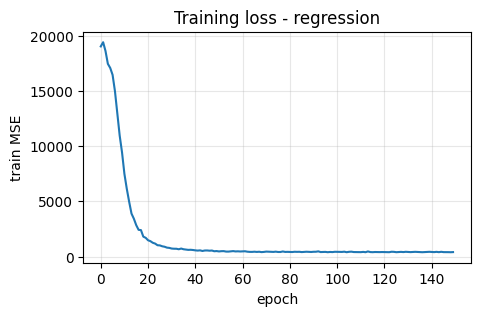

In [10]:
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(NumpyDataset(X_tr_s, y_tr), batch_size=64, shuffle=True)

train_losses = []
reg_model2.train()
for epoch in range(150):
    batch_losses = []
    for xb, yb in train_loader:
        xb, yb = xb, yb
        pred = reg_model2(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        batch_losses.append(loss.item())
    train_losses.append(np.mean(batch_losses))

plt.figure(figsize=(5,3))
plt.plot(train_losses)
plt.xlabel("epoch"); plt.ylabel("train MSE")
plt.title("Training loss - regression")
plt.grid(alpha=0.3)
plt.show()

Let’s break down what happened above step by step:

1. **Dataset and DataLoader**  
   We wrapped our numpy arrays in `NumpyDataset`, which makes them look like a PyTorch dataset.  
   Then `DataLoader` split the dataset into mini-batches of 64 rows and shuffled them each epoch.  
   This helps training be faster and more stable.

2. **Epochs and batches**  
   Each `epoch` means "one full pass over the training data".  
   Inside each epoch, we looped over mini-batches. For every batch:
   - We ran the **forward pass**: `pred = reg_model(xb)`
   - We computed the **loss**: `loss = loss_fn(pred, yb)`
   - We reset old gradients with `optimizer.zero_grad()`
   - We called `loss.backward()` so PyTorch computes gradients for each weight
   - We called `optimizer.step()` to update the weights slightly

3. **Loss tracking**  
   We stored the average loss per epoch in `train_losses`.  
   If you plot `train_losses`, you should see it go down.  
   This means the network predictions are getting closer to the true labels.


By the end of 150 epochs, the model should be much better than at the start.

---

### 2.6 Evaluate regression

We check mean squared error and plot predicted vs true `Meltig Point`.

MSE: 377.2237548828125
R2: 0.8732098937034607


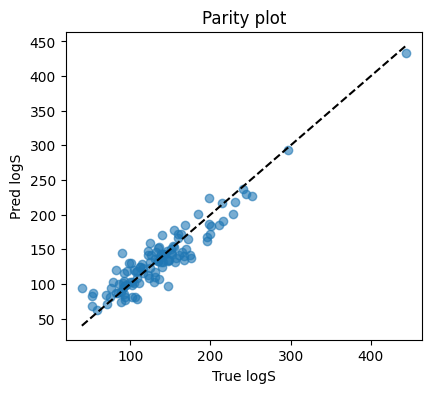

In [11]:
reg_model2.eval()
with torch.no_grad():
    yhat_te = reg_model2(torch.from_numpy(X_te_s)).cpu().numpy()

from sklearn.metrics import mean_squared_error, r2_score
print("MSE:", mean_squared_error(y_te, yhat_te))
print("R2:", r2_score(y_te, yhat_te))

plt.figure(figsize=(4.6,4))
plt.scatter(y_te, yhat_te, alpha=0.6)
lims = [min(y_te.min(), yhat_te.min()), max(y_te.max(), yhat_te.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True logS"); plt.ylabel("Pred logS")
plt.title("Parity plot")
plt.show()

This suggests our customized NN achieve a good performance on this task  :D


### 2.7 Baseline comparison

To understand how our PyTorch neural network compares to standard regressors, 
we evaluate three baselines:

- **Decision Tree Regressor**: a single non-linear tree.
- **Random Forest Regressor**: an ensemble of decision trees.
- **MLPRegressor (sklearn)**: configured to closely match our PyTorch NN.

Our PyTorch model is:  
- Input: 4 features  
- Hidden layer: 32 units with ReLU  
- Output: 1 unit  
- Optimizer: Adam with learning rate 1e-2 and weight decay 1e-3  
- Trained for 150 epochs with mini-batches of size 64.

To mirror this in `scikit-learn`, we set:

- `hidden_layer_sizes=(32,)`: one hidden layer of 32 units, just like PyTorch.  
- `activation="relu"`: same nonlinearity.  
- `solver="adam"`: same optimization family.  
- `learning_rate_init=1e-2`: match the PyTorch learning rate.  
- `alpha=1e-3`: equivalent to weight decay 1e-3.  
- `max_iter=2000`: roughly comparable to 150 epochs in Torch.


We then compare all four models (Decision Tree, Random Forest, sklearn MLP, and PyTorch NN) 
on the test set using **MSE** and **R²**.  



```{admonition} ⏰ Exercises 2.x
1) For our own NN by Pytorch change the hidden size to 64 and rerun. Does R² improve.  
2) Increase `weight_decay` to `1e-2`. What happens to train vs test scores.  

> You need to re-initialize the optimizer and re-run the training loop, as there is no `.fit(...)` function for our customized NN. In next section you will see we can wrap this
logic into a helper function to avoid repetition.
```
### 2.8 PyTorch Regressor with sklearn-like Interface

In earlier sections, we trained our custom PyTorch model by manually writing the
training loop. How can we make our customized NN feel more convenient? 

We can introduce a small wrapper called **`CHEM5080Regressor`** that makes our
PyTorch model behave like a sklearn regressor. The class builds a Sequential
network with two hidden layers (64 units with ReLU, then 32 units with Tanh),
and provides:

- `.fit(X, y)` for training
- `.predict(X)` for inference

This way, the PyTorch model can be plugged into the same workflow as Decision
Tree, Random Forest, or sklearn’s MLP. You can customize the architecture inside
`nn.Sequential` by changing the hidden sizes or swapping the activation
functions.

In [12]:
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

class CHEM5080Regressor:
    """
    A simple sklearn-like wrapper around a PyTorch feed-forward regressor.
    Architecture:
        Input -> Linear(4, 64) -> ReLU
              -> Linear(64, 32) -> ReLU
              -> Linear(32, 1)
    """
    def __init__(self, in_dim, lr=1e-2, weight_decay=1e-3, epochs=150, batch_size=64):
        # Build Sequential model
        self.model = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),         # Hidden layer 1
            nn.Linear(64, 32),
            nn.ReLU(),         # Hidden layer 2
            nn.Linear(32, 1)   # Output
        )
        # Training settings
        self.lr = lr
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)

    def fit(self, X, y):
        dataset = NumpyDataset(X, y)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        self.model.train()
        for epoch in range(self.epochs):
            for xb, yb in loader:
                pred = self.model(xb)
                loss = self.loss_fn(pred, yb)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.from_numpy(X).float()
            return self.model(X_tensor).cpu().numpy().ravel()

# --- Train and evaluate ---
chem_model = CHEM5080Regressor(in_dim=X_tr_s.shape[1], epochs=150)
chem_model.fit(X_tr_s, y_tr)
y_pred = chem_model.predict(X_te_s)

print("MSE:", mean_squared_error(y_te, y_pred))
print("R2:", r2_score(y_te, y_pred))


MSE: 387.4822998046875
R2: 0.8697618246078491


It works exactly the same way as we see in previous lectures with `sklearn`, but it was **written by ourselves**!

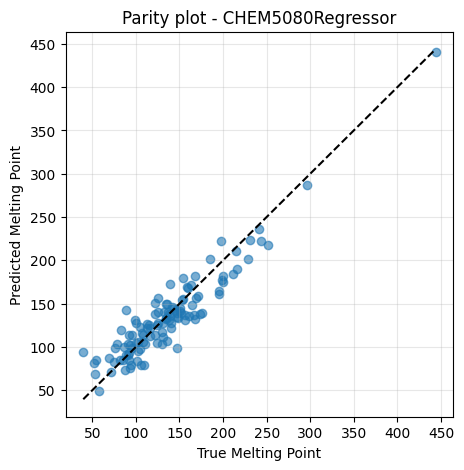

In [13]:
# --- Optional: Parity plot ---
plt.figure(figsize=(5,5))
plt.scatter(y_te, y_pred, alpha=0.6)
lims = [min(y_te.min(), y_pred.min()), max(y_te.max(), y_pred.max())]
plt.plot(lims, lims, "k--")
plt.xlabel("True Melting Point")
plt.ylabel("Predicted Melting Point")
plt.title("Parity plot - CHEM5080Regressor")
plt.grid(alpha=0.3)
plt.show()

---



## 3. Molecules as graphs


### 3.1 Why Graph?

Graphs are sets of vertices connected by edges.

Graphs are general language/data structure for describing and analyzing relational/interacting objects.

Graph machine learning tasks:

-   Graph-level prediction (Our focus today)
-   Node-level prediction
-   Edge-level prediction
-   Generation
-   Subgraph-level tasks

```{admonition} Key message
Graphs are set of nodes and edges indicating their connection.
```
Now let's look at a few examples. We first define a helper function called `draw_graph_structure()` which will take adjacency matrix to construct a graph.

In [14]:
# Get and helper function and routine to draw graph structure

def draw_graph_structure(adjacency_matrix, color=None, edge_attr=None):
    G = nx.Graph()
    n_node = adjacency_matrix.shape[0]
    for i in range(n_node):
        for j in range(i):
            if adjacency_matrix[i, j]:
                if edge_attr is not None:
                    G.add_edge(i, j, weight=edge_attr[i, j])
                else:
                    G.add_edge(i, j)

    pos = nx.spring_layout(G, seed=0)

    plt.figure(figsize=(5,5))  # keep fixed 5x5 size

    # Draw nodes
    if color is None:
        nx.draw_networkx_nodes(G, pos, node_color="lightblue")
    else:
        nx.draw_networkx_nodes(G, pos, node_color=color.flatten(), cmap=plt.cm.Set1)

    # Draw edges
    if edge_attr is not None:
        weights = [G[u][v]['weight'] for u,v in G.edges()]
        nx.draw_networkx_edges(G, pos, edge_color=weights, edge_cmap=plt.cm.Blues, width=2)
        # Optionally add edge labels
        edge_labels = {(u, v): f"{G[u][v]['weight']:.1f}" for u, v in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    else:
        nx.draw_networkx_edges(G, pos)

    nx.draw_networkx_labels(G, pos)
    plt.axis("off")
    plt.show()

Case 1:

>All nodes are identical

>All edges are identical

[[0 1 0 1 0 0 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 0 1 0 0 0]
 [1 1 0 0 1 0 0 0]
 [0 1 1 1 0 1 0 1]
 [0 0 0 0 1 0 1 1]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0]]


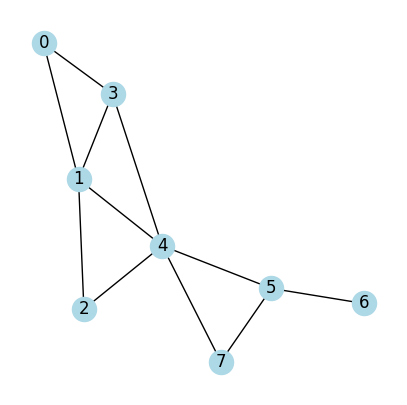

In [15]:
# An adjacency matrix define a graph
# A (adjacency matrix) of shape (num_nodes, num_nodes)
A = np.array([[0,1,0,1,0,0,0,0], #Node 0 connects to Node 1 (second) and Node 3 (fourth)
              [1,0,1,1,1,0,0,0], #Node 1 connects to Node 0 (first) and Node 2,3,4 (third to sixth on list)
              [0,1,0,0,1,0,0,0], #...
              [1,1,0,0,1,0,0,0],
              [0,1,1,1,0,1,0,1],
              [0,0,0,0,1,0,1,1],
              [0,0,0,0,0,1,0,0],
              [0,0,0,0,1,1,0,0]]);
print(A)
draw_graph_structure(A)


Case 2:

> Nodes are not identical

> All edges are identical

[[1]
 [0]
 [1]
 [2]
 [2]
 [0]
 [1]
 [1]]
[[0 1 0 1 0 0 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 0 1 0 0 0]
 [1 1 0 0 1 0 0 0]
 [0 1 1 1 0 1 0 1]
 [0 0 0 0 1 0 1 1]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0]]


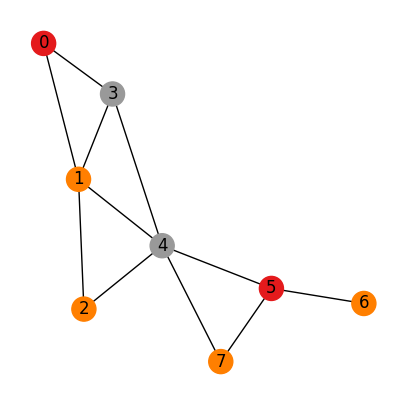

In [16]:
# Node features and adjacency matrix define a graph
# A (adjacency matrix) of shape (num_nodes, num_nodes)
# H (Node features matrix) of shape (num_nodes, dim_nodes)
A = np.array([[0,1,0,1,0,0,0,0],
              [1,0,1,1,1,0,0,0],
              [0,1,0,0,1,0,0,0],
              [1,1,0,0,1,0,0,0],
              [0,1,1,1,0,1,0,1],
              [0,0,0,0,1,0,1,1],
              [0,0,0,0,0,1,0,0],
              [0,0,0,0,1,1,0,0]])

H = np.array([
    [1],
    [0],
    [1],
    [2],
    [2],
    [0],
    [1],
    [1]
])
print(H)
print(A)
draw_graph_structure(A, color=H)

Case 3:

>Nodes are not identical

>Edges are not identical

Adjacency matrix: 
[[0 1 0 1 0 0 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 0 1 0 0 0]
 [1 1 0 0 1 0 0 0]
 [0 1 1 1 0 1 0 1]
 [0 0 0 0 1 0 1 1]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0]]


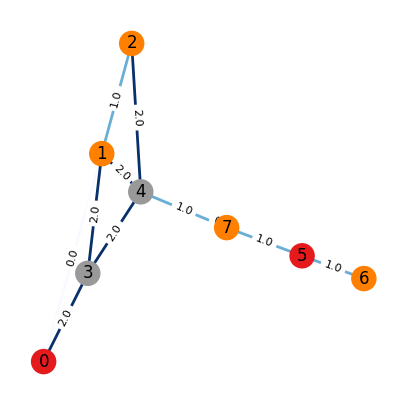

In [17]:
# An adjacency matrix define a graph
# A (adjacency matrix) of shape (num_nodes, num_nodes)
# H (Node features matrix) of shape (num_nodes, dim_nodes)
# E (Edge features tensor) of shape (num_nodes, num_nodes, dim_edges)
A = np.array([[0,1,0,1,0,0,0,0],
              [1,0,1,1,1,0,0,0],
              [0,1,0,0,1,0,0,0],
              [1,1,0,0,1,0,0,0],
              [0,1,1,1,0,1,0,1],
              [0,0,0,0,1,0,1,1],
              [0,0,0,0,0,1,0,0],
              [0,0,0,0,1,1,0,0]])

H = np.array([
    [1],
    [0],
    [1],
    [2],
    [2],
    [0],
    [1],
    [1]
])

E = np.zeros((H.shape[0], H.shape[0], 2))
for i in range(H.shape[0]):
    for j in range(H.shape[0]):
        if A[i, j] == 1:
            E[i, j, 0] = H[i, 0]
            E[i, j, 1] = H[j, 0]

print(f"Adjacency matrix: \n{A}")
#print(f"Node features matrix: \n{H}")
#print(f"Edge features tensor: \n{E}")


draw_graph_structure(A, color=H, edge_attr=E[:,:,0])

```{admonition} ⏰ **Exercises 3**

Uncomment the two `#print` statement above the interepret the output information.
```
### 3.2 Build tiny toy molecules graphs by hand

Common node features:
- One‑hot element type, degree, formal charge, aromatic flag.  
Common edge features:
- Bond type one‑hot: single, double, triple, aromatic.

We will assemble a small structure that holds:
- `x`: node feature matrix, shape `[n_nodes, d_node]`  
- `edge_index`: list of edges as two rows `[2, n_edges]`  
- `edge_attr`: edge features `[n_edges, d_edge]` (optional)  
- `y`: target for the graph



We start with first build a helper function to draw molecule.

In [18]:
import networkx as nx
def draw_molecule_from_lists(name, atoms, edges_with_bondtypes):
    """
    Build x, edge_index, edge_attr from atom + bond lists, draw colored graph,
    and print tensor shapes with edge_index table.
    """
    # ----- tensors -----
    x = np.array(atoms, dtype=np.float32)

    edge_index, edge_attr = [], []
    for (u, v, b) in edges_with_bondtypes:
        edge_index.append((u, v))
        edge_index.append((v, u))
        edge_attr.append([b])
        edge_attr.append([b])
    edge_index = np.array(edge_index, dtype=np.int64).T
    edge_attr  = np.array(edge_attr,  dtype=np.int64)

    # ----- draw -----
    color_map = {
        1: "lightgray",   # H
        6: "lightblue",   # C
        7: "lightskyblue",# N
        8: "lightcoral",  # O
        9: "lightgreen"   # F
    }
    sym = {1: "H", 6: "C", 7: "N", 8: "O", 9: "F"}

    G = nx.Graph()
    for i, atom in enumerate(x):
        Z = int(atom[0])
        G.add_node(
            i,
            label=f"{sym.get(Z, Z)}{i}",
            node_color=color_map.get(Z, "white")
        )
    for (u, v, b) in edges_with_bondtypes:
        G.add_edge(u, v, bond_type=b)

    pos = nx.spring_layout(G, seed=17)
    labels = nx.get_node_attributes(G, "label")
    node_colors = [G.nodes[n]["node_color"] for n in G.nodes()]
    nx.draw(G, pos, labels=labels, node_color=node_colors, node_size=1400, font_size=11)
    edge_labels = {(u, v): ("double" if d["bond_type"]==2 else "triple" if d["bond_type"]==3 else "single")
                   for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=14)
    plt.title(name)
    plt.axis("off")
    plt.show()

    
    # Show tensors as a table
    df = pd.DataFrame({
        "src": edge_index[0],
        "dst": edge_index[1],
        "bond_type": edge_attr.flatten()
    })
    print(f"{name}: x.shape {x.shape}, edge_index.shape {edge_index.shape}, edge_attr.shape {edge_attr.shape}")
print("Helper function [draw_molecule_from_lists] ready to use.")

Helper function [draw_molecule_from_lists] ready to use.


Methane will be our first example.

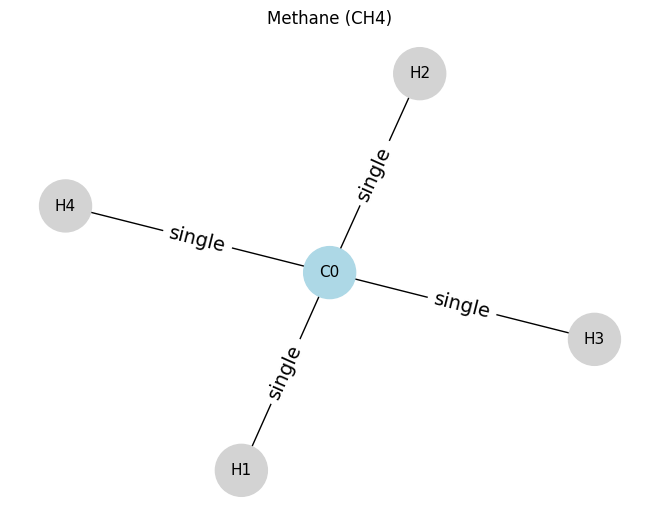

Methane (CH4): x.shape (5, 4), edge_index.shape (2, 8), edge_attr.shape (8, 1)


In [19]:
# ==== Example 1: Methane (CH4) ====
# nodes: 0=C, 1..4=H
atoms_ch4 = [
    [6, 4, 0, 0],  # C0: atomic number 6, degree 4, not aromatic, neutral
    [1, 1, 0, 0],  # H1: degree 1
    [1, 1, 0, 0],  # H2
    [1, 1, 0, 0],  # H3
    [1, 1, 0, 0],  # H4
]
edges_ch4 = [
    (0, 1, 1),  # C0-H1 single
    (0, 2, 1),  # C0-H2 single
    (0, 3, 1),  # C0-H3 single
    (0, 4, 1),  # C0-H4 single
]
draw_molecule_from_lists("Methane (CH4)", atoms_ch4, edges_ch4)

Then let's look at ethane. Compare to see the difference.

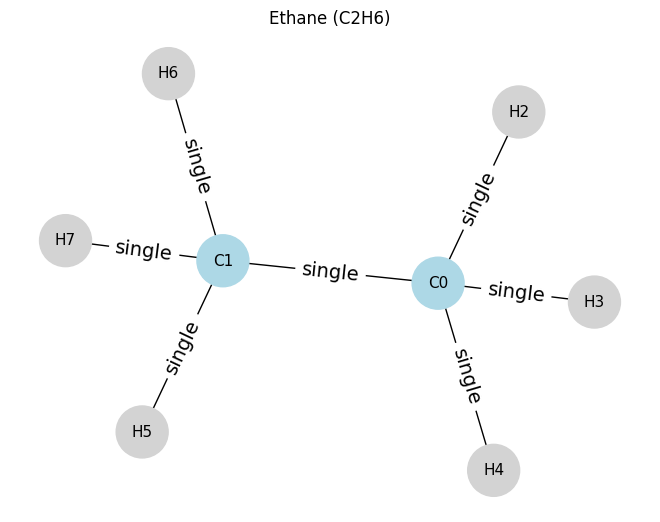

Ethane (C2H6): x.shape (8, 4), edge_index.shape (2, 14), edge_attr.shape (14, 1)


In [20]:

# ==== Example 2: Ethane (C2H6) ====
# nodes: 0=C0, 1=C1, 2..7=H
atoms_c2h6 = [
    [6, 4, 0, 0],  # C0
    [6, 4, 0, 0],  # C1
    [1, 1, 0, 0],  # H2 on C0
    [1, 1, 0, 0],  # H3 on C0
    [1, 1, 0, 0],  # H4 on C0
    [1, 1, 0, 0],  # H5 on C1
    [1, 1, 0, 0],  # H6 on C1
    [1, 1, 0, 0],  # H7 on C1
]
edges_c2h6 = [
    (0, 1, 1),  # C0-C1 single
    (0, 2, 1),  # C0-H2 single
    (0, 3, 1),  # C0-H3 single
    (0, 4, 1),  # C0-H4 single
    (1, 5, 1),  # C1-H5 single
    (1, 6, 1),  # C1-H6 single
    (1, 7, 1),  # C1-H7 single
]
draw_molecule_from_lists("Ethane (C2H6)", atoms_c2h6, edges_c2h6)

In the example below, we can see it's also possible to have a different atom and and different bond type.

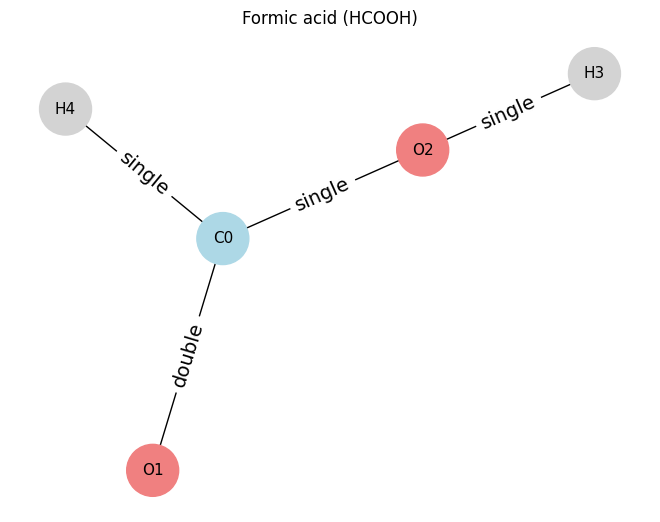

Formic acid (HCOOH): x.shape (5, 4), edge_index.shape (2, 8), edge_attr.shape (8, 1)


In [21]:
# ==== Example 3: Formic acid (HCOOH) ====
# nodes: 0=C, 1=O(double), 2=O(single with H3), 3=H on O2, 4=H on C

atoms_hcooh = [
    [6, 3, 0, 0],  # C0
    [8, 1, 0, 0],  # O1 (double bond to C0)
    [8, 2, 0, 0],  # O2 (bonded to C0 and H3)
    [1, 1, 0, 0],  # H3 (on O2)
    [1, 1, 0, 0],  # H4 (on C0)
]
edges_hcooh = [
    (0, 1, 2),  # C0=O1
    (0, 2, 1),  # C0-O2
    (2, 3, 1),  # O2-H3
    (0, 4, 1),  # C0-H4
]
draw_molecule_from_lists("Formic acid (HCOOH)", atoms_hcooh, edges_hcooh)


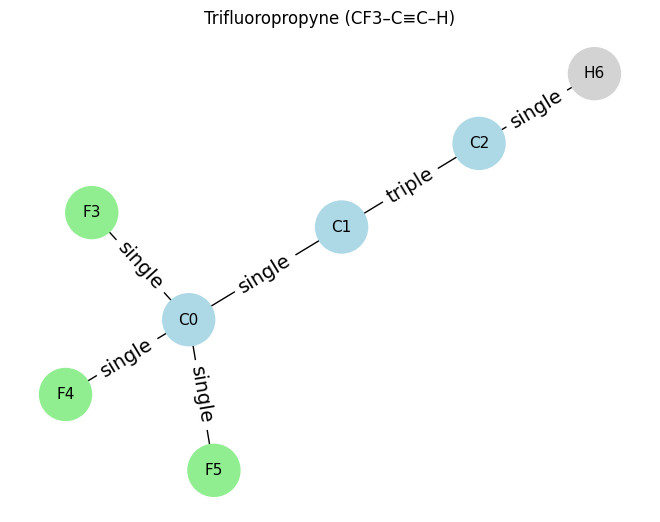

Trifluoropropyne (CF3–C≡C–H): x.shape (7, 4), edge_index.shape (2, 12), edge_attr.shape (12, 1)


In [22]:
# ==== Example 4: Trifluoropropyne (C3F3H) ====
atoms_c3hf3 = [
    [6, 4, 0, 0],  # C0 (CF3 group carbon)
    [6, 2, 0, 0],  # C1 (central carbon, part of triple bond)
    [6, 1, 0, 0],  # C2 (terminal carbon, part of triple bond)
    [9, 1, 0, 0],  # F3 (on C0)
    [9, 1, 0, 0],  # F4 (on C0)
    [9, 1, 0, 0],  # F5 (on C0)
    [1, 1, 0, 0],  # H6 (on C2)
]

edges_c3hf3 = [
    (0,1,1),  # C0–C1 single
    (1,2,3),  # C1≡C2 triple
    (0,3,1),  # C0–F3 single
    (0,4,1),  # C0–F4 single
    (0,5,1),  # C0–F5 single
    (2,6,1),  # C2–H6 single
]

draw_molecule_from_lists("Trifluoropropyne (CF3–C≡C–H)", atoms_c3hf3, edges_c3hf3)

```{admonition} ⏰ **Exercises 3.2**

Try to build a graph for `Acetonitrile` whose smiles string is `CC#N` (don't forget about hydrogen atoms!)
```




### 3.1 Molecules as graphs

A molecule can be seen as a graph:  
- **Nodes** are atoms with a feature vector per atom.  
- **Edges** are bonds that carry types such as single, double, aromatic.  
- A molecule level label (melting point, toxicity) requires **pooling** node representations into one vector.

### 3.1 Minimal node and edge features

Common node features:
- One‑hot element type, degree, formal charge, aromatic flag.  
Common edge features:
- Bond type one‑hot: single, double, triple, aromatic.

We will assemble a small structure that holds:
- `x`: node feature matrix, shape `[n_nodes, d_node]`  
- `edge_index`: list of edges as two rows `[2, n_edges]`  
- `edge_attr`: edge features `[n_edges, d_edge]` (optional)  
- `y`: target for the graph

### 3.2 Build tiny toy graphs by hand

We start with two toy molecules: Methane and Ethane.

In [23]:
def toy_methane():
    # C with 4 H; simple graph centered on C
    # nodes: 0=C, 1..4=H
    x = np.array([
        [6, 4, 0, 0],  # very small features: [atomic_number, degree, is_aromatic, formal_charge]
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0],
    ], dtype=np.float32)
    edges = []
    for h in [1,2,3,4]:
        edges += [(0, h), (h, 0)]
    edge_index = np.array(edges, dtype=np.int64).T  # shape [2, 8]
    return {"x": x, "edge_index": edge_index}

def toy_ethane():
    # C-C with 3 H on each carbon
    x = np.array([
        [6, 4, 0, 0], [6, 4, 0, 0],  # two carbons
        [1, 1, 0, 0], [1, 1, 0, 0], [1, 1, 0, 0],  # Hs on C0
        [1, 1, 0, 0], [1, 1, 0, 0], [1, 1, 0, 0],  # Hs on C1
    ], dtype=np.float32)
    edges = [(0,1),(1,0)]
    for h in [2,3,4]: edges += [(0,h),(h,0)]
    for h in [5,6,7]: edges += [(1,h),(h,1)]
    edge_index = np.array(edges, dtype=np.int64).T
    return {"x": x, "edge_index": edge_index}

g1, g2 = toy_methane(), toy_ethane()
[g1["x"].shape, g1["edge_index"].shape, g2["x"].shape, g2["edge_index"].shape]

[(5, 4), (2, 8), (8, 4), (2, 14)]

Peek at arrays to make sure the shapes are what you expect.

In [24]:
print("Methane x:\n", g1["x"])
print("Methane edges (first 6 cols):\n", g1["edge_index"][:, :6])

Methane x:
 [[6. 4. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]]
Methane edges (first 6 cols):
 [[0 1 0 2 0 3]
 [1 0 2 0 3 0]]


```{admonition} Tip
Large SMILES → RDKit graphs come later. For now the goal is to **see** the shapes and write a message passing layer on these toy graphs.
```

```{admonition} ⏰ Exercises 3.x
Add a new toy graph for **propane** with indices `[0,1,2]` as the carbon chain and correct hydrogens. Return the same keys `x` and `edge_index`. Print its shapes.
```

---

## 4. GNN and MPNN 

Let's take **Methanol (CH₃OH)** graph as an example and run both a generic **GNN** formulation and a more specific **MPNN** with full 4-dimensional features:

$
h_v^{(0)} = [Z, \text{degree}, \text{aromatic}, \text{charge}]
$

- C0: `[6, 4, 0, 0]`  
- O1: `[8, 2, 0, 0]`  
- H2,H3,H4,H5: `[1, 1, 0, 0]`  

Edges: C0–H2, C0–H3, C0–H4, C0–O1, O1–H5  

---

- **GNN (generic form)**  
  Each node aggregates features from its neighbors using a simple rule (often mean or sum), followed by a learnable transformation.  
  Equation (basic neighborhood aggregation):  

  $$h_v^{(l+1)} = \sigma\big(W_{self} h_v^{(l)} + W_{nei} \cdot \text{AGG}_{u \in N(v)} h_u^{(l)} \big)$$

  Here $h_v^{(l)}$ is the feature vector of node $v$ at layer $l$, $N(v)$ is the set of neighbors, and $\sigma$ is a nonlinearity such as ReLU.  
  In this form, all neighbors are treated the same and edge features are not used.

- **MPNN (a specific type of GNN)**  
  Each edge can carry information. Messages are computed as functions of both neighbor node states and edge features, then aggregated.  
  Equations (message passing framework):  

  $$m_{u \to v}^{(l)} = M_\theta(h_u^{(l)}, e_{uv})$$

  $$h_v^{(l+1)} = U_\theta\Big(h_v^{(l)}, \sum_{u \in N(v)} m_{u \to v}^{(l)}\Big)$$

  Here $e_{uv}$ is the feature of edge $(u,v)$ (such as bond type or bond length).  
  $M_\theta$ and $U_\theta$ are neural networks with learnable weights.  


```{admonition} Key point

MPNN is not separate from GNN — it is a more specific and chemistry-friendly formulation.  
- In the generic GNN, neighbors are aggregated without considering edge information.  
- In MPNN, messages explicitly depend on both neighbor features and edge features, which makes it well suited for molecular graphs.

```

In [25]:
atoms_ch3oh = [
    [6, 4, 0, 0],  # C0
    [8, 2, 0, 0],  # O1
    [1, 1, 0, 0],  # H2
    [1, 1, 0, 0],  # H3
    [1, 1, 0, 0],  # H4
    [1, 1, 0, 0],  # H5
]

edges_ch3oh = [
    (0,1,1), (1,0,1),  # C0-O1
    (0,2,1), (2,0,1),  # C0-H2
    (0,3,1), (3,0,1),  # C0-H3
    (0,4,1), (4,0,1),  # C0-H4
    (1,5,1), (5,1,1),  # O1-H5
]
print("Methanol atoms (node features):", atoms_ch3oh)
print("Methanol edges:", edges_ch3oh)

Methanol atoms (node features): [[6, 4, 0, 0], [8, 2, 0, 0], [1, 1, 0, 0], [1, 1, 0, 0], [1, 1, 0, 0], [1, 1, 0, 0]]
Methanol edges: [(0, 1, 1), (1, 0, 1), (0, 2, 1), (2, 0, 1), (0, 3, 1), (3, 0, 1), (0, 4, 1), (4, 0, 1), (1, 5, 1), (5, 1, 1)]


Note that, different from the previous section, here edges are usually treated as **directed**, even though chemical bonds are undirected.


Take this methanol bond `C0–O1` as an example:

In math, the bond is undirected: {C0, O1}.

But in message passing, information flows in both directions:

`C0` → `O1` (carbon sends message to oxygen)

`O1` → `C0` (oxygen sends message to carbon)

So in the edge list (edge_index) we store both directions:

> (0,1,1),  # C0 → O1, single bond


> (1,0,1),  # O1 → C0, single bond


The last number 1 is the bond type (single).

**One-layer generic (and simple) GNN calculation**

Using neighbor mean aggregation:  

$$h_v^{(l+1)} = h_v^{(l)} + 0.5 \cdot \text{mean}_{u \in N(v)} h_u^{(l)}$$

Example for Carbon (C0):  
- Neighbors: O1, H2, H3, H4  
- Mean = $([8,2,0,0] + [1,1,0,0] + [1,1,0,0] + [1,1,0,0]) / 4 = [2.75, 1.25, 0, 0]$  
- Update: $[6,4,0,0] + 0.5\cdot[2.75,1.25,0,0] = [7.375, 4.625, 0, 0]$  

We can compute similarly for O1 and hydrogens.


**One-layer MPNN calculation**

Messages are weighted by bond strength (inverse bond length, approximate values):  

- C–H: 0.92  
- C–O: 0.70  
- O–H: 1.04  

Message function:  

$$m_{u \to v} = h_u^{(l)} \cdot w(e_{uv})$$

Update:  

$$h_v^{(l+1)} = h_v^{(l)} + 0.5 \sum_{u \in N(v)} m_{u \to v}$$

Example for Carbon (C0):  
- H2 → C0: $[1,1,0,0] \times 0.92 = [0.92,0.92,0,0]$  
- H3,H4 similar  
- O1 → C0: $[8,2,0,0] \times 0.70 = [5.6,1.4,0,0]$  
- Sum = [8.36, 4.16, 0, 0]  
- Update = [6,4,0,0] + 0.5·[8.36,4.16,0,0] = [10.18, 6.08, 0, 0]  


When we apply a second layer, information propagates further:  
- In GNN, all neighbors remain equally weighted.  
- In MPNN, bond weights amplify or dampen propagation differently (O–H contributes more strongly).  

Results after 2 layers will end up with something like this: 
- GNN: C0 ≈ [10.34, 6.16, 0, 0], O1 ≈ [12.84, 4.91, 0, 0]  
- MPNN: C0 ≈ [19.09, 11.37, 0, 0], O1 ≈ [16.87, 7.11, 0, 0]  


After N layers we compute a pooled **graph vector**:  

$$h_G = \frac{1}{N}\sum_v h_v^{(L)}$$  

This graph vector goes into a final **MLP head** to predict a property (toxicity, solubility, etc.).  
Training adjusts the weights in the update rules and output MLP to minimize a loss function.

We can draw a few molecules graph with features shown on each node before and after updates.  
This lets us literally **see numbers flowing through edges** using below UI.
```{admonition} Note
For web users, please open Colab (link on the top of the page) to run below module. HTML will not be able to update the calculation.
```

In [26]:
# Node features = [type_Z, degree, formal_charge, aromatic_flag]
# Edge weights = bond length in Angstroms (Å)  [default], with optional inverse-length toggle
# Molecules: Chain, Methane (CH4), Propene (C3H6), Formic acid (HCOOH)


# --------------------------- Utilities ---------------------------
def node_feature_matrix(Z_list, bonds, formal_charges=None, aromatic_flags=None):
    """
    Build x from chemistry-style features:
    x[i] = [type_Z, degree, formal_charge, aromatic_flag]
    - type_Z: atomic number (float)
    - degree: number of incident bonds
    - formal_charge: default 0
    - aromatic_flag: 0/1, default 0
    """
    N = len(Z_list)
    deg = np.zeros(N, dtype=float)
    for u, v, *_ in bonds:
        deg[u] += 1.0
        deg[v] += 1.0
    if formal_charges is None:
        formal_charges = np.zeros(N, dtype=float)
    if aromatic_flags is None:
        aromatic_flags = np.zeros(N, dtype=float)
    x = np.stack([np.array(Z_list, dtype=float),
                  deg,
                  np.array(formal_charges, dtype=float),
                  np.array(aromatic_flags, dtype=float)], axis=1)
    return x

def expand_edges(bonds):
    """
    bonds: list of (u, v, length_A, optional_label)
    Return directed edge_index [2,E] and edge_weight [E] (length in Å)
    """
    ei = []
    ew = []
    for b in bonds:
        if len(b) == 3:
            u, v, L = b
        else:
            u, v, L, _ = b
        ei += [(u, v), (v, u)]
        ew += [L, L]
    return np.array(ei, dtype=int).T, np.array(ew, dtype=float)

# ----------------------- Molecule builders -----------------------
def mol_methane():
    # Nodes: 0=C, 1..4=H; approx C-H 1.09 Å
    Z = [6, 1, 1, 1, 1]
    bonds = [(0, 1, 1.09), (0, 2, 1.09), (0, 3, 1.09), (0, 4, 1.09)]
    x = node_feature_matrix(Z, bonds)
    edge_index, edge_w = expand_edges(bonds)
    labels = ["C0", "H1", "H2", "H3", "H4"]
    colors = ["lightblue", "lightgray", "lightgray", "lightgray", "lightgray"]
    return x, edge_index, edge_w, labels, colors

def mol_propene():
    # Propene CH3-CH=CH2
    # Typical lengths: C–C 1.54 Å, C=C 1.34 Å, C–H 1.09 Å
    Z = [6, 6, 6, 1, 1, 1, 1, 1, 1]
    bonds = [
        (0, 1, 1.54, "C-C"),
        (1, 2, 1.34, "C=C"),
        (0, 3, 1.09), (0, 4, 1.09), (0, 5, 1.09),
        (1, 6, 1.09),
        (2, 7, 1.09), (2, 8, 1.09),
    ]
    x = node_feature_matrix(Z, bonds)
    edge_index, edge_w = expand_edges(bonds)
    labels = ["C0", "C1", "C2", "H3", "H4", "H5", "H6", "H7", "H8"]
    colors = ["lightblue"]*3 + ["lightgray"]*6
    return x, edge_index, edge_w, labels, colors

def mol_formic_acid():
    # Formic acid HCOOH (indices: C0, O1, O2, H3(on O2), H4(on C))
    # Typical lengths (Å): C=O 1.23, C–O 1.36, O–H 0.96, C–H 1.09
    Z = [6, 8, 8, 1, 1]
    bonds = [
        (0, 1, 1.23, "C=O"),
        (0, 2, 1.36, "C–O"),
        (2, 3, 0.96, "O–H"),
        (0, 4, 1.09, "C–H"),
    ]
    x = node_feature_matrix(Z, bonds)
    edge_index, edge_w = expand_edges(bonds)
    labels = ["C0", "O1", "O2", "H3", "H4"]
    colors = ["lightblue", "lightcoral", "lightcoral", "lightgray", "lightgray"]
    return x, edge_index, edge_w, labels, colors

def mol_methanol():
    # Methanol CH3OH
    # Typical lengths (Angstrom): C-O 1.43, O-H 0.96, C-H 1.09
    # Indices: C0, O1, H2/H3/H4 on C, H5 on O
    Z = [6, 8, 1, 1, 1, 1]
    bonds = [
        (0, 1, 1.43, "C-O"),
        (1, 5, 0.96, "O-H"),
        (0, 2, 1.09, "C-H"),
        (0, 3, 1.09, "C-H"),
        (0, 4, 1.09, "C-H"),
    ]
    x = node_feature_matrix(Z, bonds)
    edge_index, edge_w = expand_edges(bonds)
    labels = ["C0", "O1", "H2", "H3", "H4", "H5"]
    colors = ["lightblue", "lightcoral", "lightgray", "lightgray", "lightgray", "lightgray"]
    return x, edge_index, edge_w, labels, colors

def graph_chain():  # keep a neutral toy
    Z = [0, 0, 0, 0]  # type not meaningful here
    bonds = [(0,1,1.0),(1,2,1.0),(2,3,1.0)]
    x = node_feature_matrix(Z, bonds)
    ei = []
    for u, v, L in bonds:
        ei += [(u,v),(v,u)]
    edge_index = np.array(ei, dtype=int).T
    edge_w = np.ones(edge_index.shape[1], dtype=float)
    labels = [f"Node {i}" for i in range(4)]
    colors = None
    return x, edge_index, edge_w, labels, colors

BUILDERS = {
    "Methane CH4": mol_methane,
    "Propene C3H6": mol_propene,
    "Formic acid HCOOH": mol_formic_acid,
    "Methanol CH3OH": mol_methanol,   # <— new
    "Chain 0-1-2-3": graph_chain,
}

# -------------------- Message passing math --------------------
def aggregate(x, edge_index, edge_w, how="Mean", weight_mode="Length"):
    """
    Aggregate neighbor vectors with edge weights.
    - how: "Mean" or "Sum"
    - weight_mode: "Length" (multiply by L) or "Inverse length" (multiply by 1/L)
    """
    src, dst = edge_index
    N, D = x.shape
    agg = np.zeros((N, D), dtype=float)
    for e in range(src.shape[0]):
        w = edge_w[e]
        if weight_mode == "Inverse length":
            w = 1.0 / max(w, 1e-6)
        agg[dst[e]] += w * x[src[e]]
    if how == "Mean":
        deg = np.zeros(N, dtype=float)
        for d in dst:
            deg[d] += 1.0
        deg = np.maximum(deg, 1.0)
        agg = agg / deg[:, None]
    return agg

def activate(z, kind="tanh"):
    if kind == "Identity": return z
    if kind == "ReLU":     return np.maximum(z, 0.0)
    if kind == "tanh":     return np.tanh(z)
    return z

def one_step(x, edge_index, edge_w, a=0.6, b=0.8, agg="Mean", act="tanh", safety=True, weight_mode="Length"):
    nei = aggregate(x, edge_index, edge_w, how=agg, weight_mode=weight_mode)
    z = a * x + b * nei
    h = activate(z, kind=act)
    if safety:
        norms = np.linalg.norm(h, axis=1, keepdims=True) + 1e-8
        scale = np.minimum(1.0, 2.0 / norms)
        h = h * scale
    return h

# ------------------------- Drawing -------------------------
COLORS = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

def show_vectors(vectors, labels, title):
    N, D = vectors.shape
    fig, ax = plt.subplots(figsize=(1.7*N + 2.0, 3.8))
    ax.set_xlim(0, N)
    ax.set_ylim(-0.5, 4.7)
    ax.axis("off")
    ax.set_title(title, pad=10)
    for i in range(N):
        x_left, x_right = i + 0.1, i + 0.9
        ax.plot([x_left, x_left], [0, 4], color="black", linewidth=2)
        ax.plot([x_right, x_right], [0, 4], color="black", linewidth=2)
        ax.plot([x_left, x_right], [4, 4], color="black", linewidth=2)
        ax.plot([x_left, x_right], [0, 0], color="black", linewidth=2)
        ax.text((x_left+x_right)/2, 4.3, labels[i], ha="center", va="bottom", fontsize=11)
        for k in range(4):
            ax.text((x_left+x_right)/2, 3.5 - k, f"[ {vectors[i,k]:+.2f} ]",
                    ha="center", va="center", fontsize=12, color=COLORS[k])
    plt.show()

def show_graph(edge_index, labels, node_colors, title="Molecule/graph connectivity"):
    src, dst = edge_index
    edges = list(set(tuple(sorted((int(u), int(v)))) for u, v in zip(src, dst) if u != v))
    G = nx.Graph()
    for i, lab in enumerate(labels):
        G.add_node(i, label=lab)
    for u, v in edges:
        G.add_edge(u, v)
    pos = nx.spring_layout(G, seed=7)
    fig, ax = plt.subplots(figsize=(5.5, 5.0))
    if node_colors is None:
        nx.draw(G, pos, with_labels=True, labels={i: labels[i] for i in range(len(labels))},
                node_size=1200, font_size=10)
    else:
        nx.draw(G, pos, with_labels=True, labels={i: labels[i] for i in range(len(labels))},
                node_size=1200, font_size=10, node_color=node_colors)
    ax.set_title(title)
    plt.show()

# ----------------------- Widget UI or Fallback -----------------------
WIDGETS_AVAILABLE = False
try:
    import ipywidgets as widgets
    from IPython.display import display
    WIDGETS_AVAILABLE = True
except Exception:
    pass

def run_demo(name="Methane CH4", steps=3, agg="Mean", act="tanh", a=0.6, b=0.8, safety=True, weight_mode="Length"):
    x, ei, ew, labels, colors = BUILDERS[name]()
    show_graph(ei, labels, colors, title=f"{name} — bonds")
    h = x.copy()
    for _ in range(steps):
        h = one_step(h, ei, ew, a=a, b=b, agg=agg, act=act, safety=safety, weight_mode=weight_mode)
    show_vectors(h, labels, title=f"After {steps} step(s) • agg={agg}, act={act}, a={a}, b={b}, safety={safety}, weight={weight_mode}")

if WIDGETS_AVAILABLE:
    graph_dd   = widgets.Dropdown(options=list(BUILDERS.keys()), value="Methanol CH3OH", description="Molecule")
    steps_sl   = widgets.IntSlider(min=0, max=10, step=1, value=0, description="Steps")
    agg_tb     = widgets.ToggleButtons(options=["Mean","Sum"], value="Sum", description="Aggregate")
    act_tb     = widgets.ToggleButtons(options=["tanh","ReLU","Identity"], value="Identity", description="Activation")
    a_sl       = widgets.FloatSlider(min=0.0, max=1.5, step=0.05, value=1.0, description="Self (a)")
    b_sl       = widgets.FloatSlider(min=0.0, max=1.5, step=0.05, value=0.5, description="Neighbor (b)")
    safety_cb  = widgets.Checkbox(value=False, description="Renormalization / Safety Scale")
    weight_tb  = widgets.ToggleButtons(options=["Length","Inverse length"], value="Inverse length", description="Edge feature")

    run_btn    = widgets.Button(description="Run")
    out_graph = widgets.Output()
    out_vec   = widgets.Output()

    def on_run(_):
        out_graph.clear_output(wait=True); out_vec.clear_output(wait=True)
        with out_graph:
            x, ei, ew, labels, colors = BUILDERS[graph_dd.value]()
            show_graph(ei, labels, colors, title=f"{graph_dd.value} — bonds (Å weighting)")
        with out_vec:
            h = x.copy()
            for _ in range(steps_sl.value):
                h = one_step(h, ei, ew, a=a_sl.value, b=b_sl.value,
                             agg=agg_tb.value, act=act_tb.value,
                             safety=safety_cb.value, weight_mode=weight_tb.value)
            show_vectors(h, labels, title=f"After {steps_sl.value} step(s) • agg={agg_tb.value}, act={act_tb.value}, a={a_sl.value}, b={b_sl.value}, safety={safety_cb.value}, weight={weight_tb.value}")
    run_btn.on_click(on_run)
    display(widgets.VBox([
        widgets.HBox([graph_dd, steps_sl, weight_tb]),
        widgets.HBox([agg_tb, act_tb]),
        widgets.HBox([a_sl, b_sl, safety_cb, run_btn]),
        widgets.HBox([out_graph, out_vec])
    ]))
    on_run(None)
else:
    # Fallback run here so you can see the revised initialization and new Formic acid example
    run_demo(name="Methanol CH3OH", steps=0, agg="Mean", act="Identity", a=1.0, b=0.5, safety=False, weight_mode="Inverse length")

## 5. Build an MPNN from scratch

Now that we've seen the math for message passing, we will implement a
simple **MPNN layer** in PyTorch and use it for a toxicity classification task.


At each layer `t`, every node gets messages from its neighbors and updates its hidden state.

A simple form:

$$
h_v^{(t+1)} = \sigma\left(W_\text{self}\, h_v^{(t)} + \sum_{u \in \mathcal{N}(v)} W_\text{nei}\, h_u^{(t)} + b\right)
$$

- `h_v` is the node vector at layer `t`.  
- `W_self` maps the node to itself.  
- `W_nei` maps neighbor messages.  
- Sum neighbor messages, then apply a nonlinearity `σ` such as ReLU.

After `T` layers, pool all node vectors to get a graph vector:

$$
h_\text{graph} = \text{POOL}\left(\{h_v^{(T)} : v \in \text{nodes}\}\right)
$$

POOL can be **sum**, **mean**, or **max**. For regression we feed `h_graph` to a linear head to predict a scalar.


We will use RDKit to parse SMILES strings and turn molecules into
graphs.

In [27]:
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")
    # Ensure we have atom indices in the depiction later
    mol = Chem.AddHs(mol)  # to make hydrogens explicit for clearer tables
    Chem.SanitizeMol(mol)
    x = []
    for atom in mol.GetAtoms():
        x.append([
            atom.GetAtomicNum(),
            atom.GetDegree(),          # degree counts explicit neighbors
            atom.GetFormalCharge(),
            1 if atom.GetIsAromatic() else 0
        ])
    edge_index = []
    edge_attr = []
    bond_type_map = {
        Chem.rdchem.BondType.SINGLE: 1,
        Chem.rdchem.BondType.DOUBLE: 2,
        Chem.rdchem.BondType.TRIPLE: 3,
        Chem.rdchem.BondType.AROMATIC: 0
    }
    for bond in mol.GetBonds():
        u, v = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        bt = bond_type_map.get(bond.GetBondType(), 0)
        edge_index += [(u, v), (v, u)]
        edge_attr += [[bt], [bt]]
    x = np.array(x, dtype=np.float32)
    edge_index = np.array(edge_index, dtype=np.int64).T  # [2, E]
    edge_attr = np.array(edge_attr, dtype=np.int64)      # [E, 1]
    return mol, x, edge_index, edge_attr

def atom_df(mol, x):
    rows = []
    for i, atom in enumerate(mol.GetAtoms()):
        rows.append({
            "idx": i,
            "symbol": atom.GetSymbol(),
            "Z": int(x[i,0]),
            "degree": int(x[i,1]),
            "formal_charge": int(x[i,2]),
            "aromatic": bool(x[i,3]),
        })
    return pd.DataFrame(rows)

def bond_df(mol, edge_index, edge_attr):
    # collapse directed edges to undirected unique bonds
    seen = set()
    rows = []
    for b in mol.GetBonds():
        u, v = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        key = tuple(sorted((u, v)))
        if key in seen: 
            continue
        seen.add(key)
        bt = b.GetBondType().name
        rows.append({
            "u": key[0],
            "v": key[1],
            "bond_type": bt
        })
    return pd.DataFrame(rows)

def draw_mol(mol, title):
    try:
        img = Draw.MolToImage(mol, size=(400, 300), kekulize=True)
        plt.figure(figsize=(4,3))
        plt.imshow(img)
        plt.axis("off")
        plt.title(title)
        plt.show()
    except:
        # Fallback: NetworkX from connectivity
        import networkx as nx
        G = nx.Graph()
        for atom in mol.GetAtoms():
            G.add_node(atom.GetIdx(), label=f"{atom.GetSymbol()}{atom.GetIdx()}")
        for bond in mol.GetBonds():
            u, v = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            G.add_edge(u, v)
        pos = nx.spring_layout(G, seed=7)
        labels = nx.get_node_attributes(G, "label")
        plt.figure(figsize=(4,3))
        nx.draw(G, pos, with_labels=True, labels=labels, node_size=800)
        plt.title(title)
        plt.show()

In [28]:
examples = {
    "Ethanol (CCO)": "CCO",
    "Acetonitrile (CC#N)": "CC#N",
    "Formic acid (OC=O)": "OC=O",
    "Propene (C=CC)": "C=CC",
}

for name, smi in examples.items():
    try:
        mol, x, ei, ea = smiles_to_graph(smi)
        # DataFrames
        adf = atom_df(mol, x)
        bdf = bond_df(mol, ei, ea)

        # Shapes
        print(f'Example: {name}')
        print(f"x.shape {x.shape}, edge_index.shape {ei.shape}, edge_attr.shape {ea.shape}")
        print("Atom features:", x)
        print("Bond features (first three):", edge_attr[:3])
        # Drawing (with atom indices rendered by RDKit via AddHs)
        draw_mol(mol, f"{name} (with explicit H)")
        print("------------------------------------")
    except Exception as e:
        print(f"{name}: error -> {e}")

Example: Ethanol (CCO)
x.shape (9, 4), edge_index.shape (2, 16), edge_attr.shape (16, 1)
Atom features: [[6. 4. 0. 0.]
 [6. 4. 0. 0.]
 [8. 2. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]]
Ethanol (CCO): error -> name 'edge_attr' is not defined
Example: Acetonitrile (CC#N)
x.shape (6, 4), edge_index.shape (2, 10), edge_attr.shape (10, 1)
Atom features: [[6. 4. 0. 0.]
 [6. 2. 0. 0.]
 [7. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]]
Acetonitrile (CC#N): error -> name 'edge_attr' is not defined
Example: Formic acid (OC=O)
x.shape (5, 4), edge_index.shape (2, 8), edge_attr.shape (8, 1)
Atom features: [[8. 2. 0. 0.]
 [6. 3. 0. 0.]
 [8. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]]
Formic acid (OC=O): error -> name 'edge_attr' is not defined
Example: Propene (C=CC)
x.shape (9, 4), edge_index.shape (2, 16), edge_attr.shape (16, 1)
Atom features: [[6. 3. 0. 0.]
 [6. 3. 0. 0.]
 [6. 4. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [

Now, let's define a simple MPNN. Each node aggregates neighbor messages weighted by edge type embeddings.

Below you will see it has two parts:

___

1. `MPNNLayer`

This is a single message-passing step.

Its job is to update each node’s representation by combining:

The node’s own features (`W_self(x)`).

Messages from its neighbors (`W_nei(pre_msg)`), where edges add context.

The layer outputs a new embedding for every node in the graph: `[N, out_dim]`.

Think of it like one "round of communication" between nodes.

___

2. `MPNNClassifier`

This is the full model that stacks multiple MPNNLayers to capture more complex dependencies.

`self.layer1` → does the first message passing.

`self.layer2` → refines node embeddings further.

After the message passing, you now have updated node features (`h`).

But for graph classification you need a single vector for the whole graph. That’s where pooling comes in:

> h_graph = h.mean(dim=0)


This aggregates node embeddings into one graph embedding.

Finally, `self.fc` maps that graph embedding to class logits (`n_classes`).

In [29]:
class MPNNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, n_edge_types=4):
        super().__init__()
        self.W_self = nn.Linear(in_dim, out_dim)
        self.W_nei  = nn.Linear(in_dim, out_dim)
        self.edge_emb = nn.Embedding(n_edge_types, in_dim)  # embeds to in_dim

    def forward(self, x, edge_index, edge_attr):
        # x: [N, in_dim], edge_index: [2, E], edge_attr: [E, 1] (long)
        row, col = edge_index  # messages from row -> col
        edge_feat = self.edge_emb(edge_attr.squeeze())      # [E, in_dim]

        # message computation (still in in_dim before W_nei)
        pre_msg = x[row] + edge_feat                        # [E, in_dim]
        messages = self.W_nei(pre_msg)                      # [E, out_dim]

        # aggregate into [N, out_dim] on the same device and dtype
        out_dim = self.W_nei.out_features
        agg = x.new_zeros(x.size(0), out_dim)               # [N, out_dim]
        agg.index_add_(0, col, messages)                    # sum over incoming edges

        out = self.W_self(x) + agg                          # [N, out_dim]
        return torch.relu(out)

class MPNNClassifier(nn.Module):
    def __init__(self, in_dim, hidden=64, n_classes=2):
        super().__init__()
        self.layer1 = MPNNLayer(in_dim, hidden)
        self.layer2 = MPNNLayer(hidden, hidden)
        self.fc = nn.Linear(hidden, n_classes)

    def forward(self, data):
        x, edge_index, edge_attr = data["x"], data["edge_index"], data["edge_attr"]
        h = self.layer1(x, edge_index, edge_attr)
        h = self.layer2(h, edge_index, edge_attr)
        h_graph = h.mean(dim=0)  # mean pooling
        return self.fc(h_graph)

# below is an optional sanity check right after defining the layer:        
tmp = MPNNLayer(4, 64)
with torch.no_grad():
    x = torch.randn(19, 4)
    edge_index = torch.tensor([[0,1,2,3],[1,2,3,4]])  # toy edges
    edge_attr  = torch.zeros(edge_index.size(1), 1, dtype=torch.long)
    y = tmp(x, edge_index, edge_attr)
    print(y.shape)  # should be [19, 64]


torch.Size([19, 64])


We reuse the oxidation dataset, map SMILES → graphs, and toxicity → label.

In [30]:

url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)

label_map = {"toxic":1, "non_toxic":0}
df_clf = df_raw[df_raw["Toxicity"].str.lower().isin(label_map.keys())]

# Convert (mol, x_np, edge_index_np, edge_attr_np) -> dict of torch tensors
def tuple_to_graphdict(g_tuple):
    mol, x_np, ei_np, ea_np = g_tuple
    g = {
        "x": torch.tensor(x_np, dtype=torch.float),
        "edge_index": torch.tensor(ei_np, dtype=torch.long),
        "edge_attr": torch.tensor(ea_np, dtype=torch.long),  # shape [E,1], ints
        # keep mol if you want later:
        # "mol": mol
    }
    return g

graphs = []
labels = []
for smi, lab in zip(df_clf["SMILES"], df_clf["Toxicity"].str.lower().map(label_map)):
    t = smiles_to_graph(smi)     # still returns the 4-tuple
    if t is None:
        continue
    g = tuple_to_graphdict(t)    # convert to dict of tensors
    g["y"] = torch.tensor(lab, dtype=torch.long)
    graphs.append(g)
    labels.append(lab)

print("Total graphs:", len(graphs))


Total graphs: 575


We will keep it very small: 80/20 split, train for a few epochs.

In [31]:
train_idx, test_idx = train_test_split(range(len(graphs)), test_size=0.2, random_state=42, stratify=labels)
train_graphs = [graphs[i] for i in train_idx]
test_graphs  = [graphs[i] for i in test_idx]

model = MPNNClassifier(in_dim=4, hidden=64, n_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

def train_epoch(graphs):
    model.train()
    total_loss = 0
    for g in graphs:
        optimizer.zero_grad()
        out = model(g).unsqueeze(0)
        loss = loss_fn(out, g["y"].unsqueeze(0))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(graphs)

def eval_acc(graphs):
    model.eval()
    correct = 0
    with torch.no_grad():
        for g in graphs:
            out = model(g).unsqueeze(0)
            pred = out.argmax(dim=1)
            correct += (pred == g["y"]).sum().item()
    return correct / len(graphs)

for epoch in range(10):
    loss = train_epoch(train_graphs)
    acc = eval_acc(test_graphs)
    print(f"Epoch {epoch:02d} | Loss {loss:.3f} | Test acc {acc:.3f}")


Epoch 00 | Loss 0.471 | Test acc 0.826


Epoch 01 | Loss 0.423 | Test acc 0.826


Epoch 02 | Loss 0.414 | Test acc 0.826


Epoch 03 | Loss 0.408 | Test acc 0.826


Epoch 04 | Loss 0.403 | Test acc 0.826


Epoch 05 | Loss 0.398 | Test acc 0.826


Epoch 06 | Loss 0.393 | Test acc 0.826


Epoch 07 | Loss 0.387 | Test acc 0.826


Epoch 08 | Loss 0.383 | Test acc 0.817


Epoch 09 | Loss 0.377 | Test acc 0.809


```{admonition} ⏰**Exercises**
Change `epoch` from `10` to `40` to see the difference.
```

This gives an test acc around `0.85`, which is quite nice (since we have not done any optimization on 

The other thing you may notice is that, since we use molecule as graph, this time we **did not** provide molecular level descritors like `MolWt`, `LogP`, `TPSA`, `#Rings`, instead we simply just put some simple atomic level information like atomic number and bond order.

Similar to the case you see earlier today with MLP, we can also have customized `.fit()` and `.predict()` function.

In [32]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)

def _to_device_graph(g, device):
    out = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in g.items()}
    return out

class CHEM5080_MPNNClassifierWrapper:
    """
    A lightweight sklearn-style wrapper:
      - fit(graphs)
      - predict(graphs)
      - predict_proba(graphs)
      - score(graphs, y_true) -> accuracy
    Expects each graph g to include g["y"] as a scalar LongTensor (class id).
    """
    def __init__(self,
                 in_dim: int,
                 n_classes: int,
                 hidden: int = 64,
                 lr: float = 1e-3,
                 weight_decay: float = 1e-4,
                 epochs: int = 30,
                 device: str = None,
                 print_every: int = 1):
        self.in_dim = in_dim
        self.n_classes = n_classes
        self.hidden = hidden
        self.lr = lr
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.print_every = print_every
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        self.model = MPNNClassifier(in_dim=in_dim, hidden=hidden, n_classes=n_classes).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.loss_fn = nn.CrossEntropyLoss()

    def fit(self, graphs, val_graphs=None):
        """
        Trains for self.epochs over the list of graphs.
        If val_graphs is provided, reports validation accuracy each epoch.
        """
        self.model.train()
        best_state = None
        best_val = -math.inf

        for epoch in range(1, self.epochs + 1):
            total_loss = 0.0
            self.model.train()
            for g in graphs:
                g = _to_device_graph(g, self.device)
                self.optimizer.zero_grad()
                logits = self.model(g).unsqueeze(0)           # [1, C]
                loss = self.loss_fn(logits, g["y"].unsqueeze(0).to(self.device))
                loss.backward()
                self.optimizer.step()
                total_loss += float(loss.item())

            avg_loss = total_loss / max(1, len(graphs))

            msg = f"Epoch {epoch:02d} | train_loss {avg_loss:.4f}"
            if val_graphs is not None:
                acc = self.score(val_graphs)
                msg += f" | val_acc {acc:.4f}"
                # keep best
                if acc > best_val:
                    best_val = acc
                    best_state = copy.deepcopy(self.model.state_dict())

            if self.print_every and (epoch % self.print_every == 0):
                print(msg)

        if best_state is not None:
            self.model.load_state_dict(best_state)

        return self

    @torch.no_grad()
    def predict_proba(self, graphs):
        """
        Returns numpy array of class probabilities with shape [N, n_classes].
        """
        self.model.eval()
        probs = []
        for g in graphs:
            g = _to_device_graph(g, self.device)
            logits = self.model(g).unsqueeze(0)               # [1, C]
            p = F.softmax(logits, dim=1).cpu().numpy()        # [1, C]
            probs.append(p[0])
        return np.vstack(probs)

    @torch.no_grad()
    def predict(self, graphs):
        """
        Returns numpy int array of predicted class ids with shape [N].
        """
        prob = self.predict_proba(graphs)
        return prob.argmax(axis=1).astype(np.int64)

    @torch.no_grad()
    def score(self, graphs, y_true=None):
        """
        Accuracy. If y_true is None, reads g['y'] for each graph.
        """
        self.model.eval()
        correct = 0
        total = 0
        if y_true is None:
            y_true = [int(g["y"].item()) for g in graphs]
        preds = self.predict(graphs)
        return float((preds == np.array(y_true)).sum() / len(preds))


# ===== Tiny hyperparameter search (grid) =====
def grid_search_graphclf(
    param_grid: dict,
    train_graphs: list,
    val_graphs: list,
    in_dim: int,
    n_classes: int,
    seed: int = 42,
):
    set_seed(seed)
    keys = list(param_grid.keys())

    # build all combos
    from itertools import product
    values = [param_grid[k] for k in keys]
    combos = [dict(zip(keys, vals)) for vals in product(*values)]

    best_acc = -math.inf
    best_model = None
    best_params = None
    history = []

    for i, params in enumerate(combos, 1):
        cfg = dict(hidden=64, lr=1e-3, weight_decay=1e-4, epochs=30)  # defaults
        cfg.update(params)

        print(f"[{i}/{len(combos)}] testing {cfg}")
        model = CHEM5080_MPNNClassifierWrapper(
            in_dim=in_dim,
            n_classes=n_classes,
            hidden=cfg["hidden"],
            lr=cfg["lr"],
            weight_decay=cfg["weight_decay"],
            epochs=cfg["epochs"],
            print_every=0
        )
        model.fit(train_graphs, val_graphs=val_graphs)
        acc = model.score(val_graphs)
        history.append((cfg, acc))
        print(f"  val_acc={acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_model = model
            best_params = cfg

    print(f"\nBest val_acc={best_acc:.4f} with params={best_params}")
    return best_model, best_params, history



Below you will see we have this new toy `CHEM5080_MPNNClassifierWrapper` for us to make prediction just like the way you did for lasso, decision tree and random forest in previous lectures.

In [33]:
train_idx, test_idx = train_test_split(
    range(len(graphs)), test_size=0.2, random_state=42, stratify=labels
)
train_graphs = [graphs[i] for i in train_idx]
test_graphs  = [graphs[i] for i in test_idx]

# Train a single model
clf = CHEM5080_MPNNClassifierWrapper(in_dim=4, n_classes=2, hidden=64, lr=1e-3, weight_decay=1e-4, epochs=10)
clf.fit(train_graphs, val_graphs=test_graphs)

# Evaluate
print("Test accuracy:", clf.score(test_graphs))

# Predict labels and probabilities
y_hat = clf.predict(test_graphs)           # int class ids
p_hat = clf.predict_proba(test_graphs)  

Epoch 01 | train_loss 0.4850 | val_acc 0.8261


Epoch 02 | train_loss 0.4325 | val_acc 0.8261


Epoch 03 | train_loss 0.4176 | val_acc 0.8261


Epoch 04 | train_loss 0.4117 | val_acc 0.8261


Epoch 05 | train_loss 0.4078 | val_acc 0.8261


Epoch 06 | train_loss 0.4035 | val_acc 0.8261


Epoch 07 | train_loss 0.3995 | val_acc 0.8261


Epoch 08 | train_loss 0.3972 | val_acc 0.8261


Epoch 09 | train_loss 0.3920 | val_acc 0.8261


Epoch 10 | train_loss 0.3866 | val_acc 0.8261
Test accuracy: 0.8260869565217391


We can also try to tune the hyperparameters.  
Since running a full search with GNNs is more time-consuming than the other models we saw earlier (like Decision Trees or scikit-learn MLPs), we will just keep the grid small to give you an idea of the tuning process.

Since we run this on CPU, you may find the training relatively slow compared to even feed-forward models, because each epoch processes graphs one by one and the message passing layers are more complex. In practice, GPUs help but do not fully remove this bottleneck — batching and optimized data loaders become more important.

The code below can be excecuted at google colab.



```python
param_grid = {
    "hidden": [8, 32, 128],
    "lr": [1e-3, 5e-4],
    "weight_decay": [1e-4, 5e-5],
    "epochs": [30]
}

best_model, best_params, hist = grid_search_graphclf(
    param_grid=param_grid,
    train_graphs=train_graphs,
    val_graphs=test_graphs,   # or a proper validation set if you have one
    in_dim=4,
    n_classes=2,
    seed=42
)

print("Best params:", best_params)
print("Best model test accuracy:", best_model.score(test_graphs))

```
Sample output:
>[1/12] testing {'hidden': 8, 'lr': 0.001, 'weight_decay': 0.0001, 'epochs': 30}
  val_acc=0.8348
>[2/12] testing {'hidden': 8, 'lr': 0.001, 'weight_decay': 5e-05, 'epochs': 30}
  val_acc=0.8261
>[3/12] testing {'hidden': 8, 'lr': 0.0005, 'weight_decay': 0.0001, 'epochs': 30}
  val_acc=0.8348
>[4/12] testing {'hidden': 8, 'lr': 0.0005, 'weight_decay': 5e-05, 'epochs': 30}
  val_acc=0.8261
>[5/12] testing {'hidden': 32, 'lr': 0.001, 'weight_decay': 0.0001, 'epochs': 30}
  val_acc=0.8435
...

```{admonition} ⏰ **Exercises 6**
Change the number of MPNN layers in `MPNNClassifier()`. Run again the training and tetsing to see any difference.

```







---


## 7. Glossary

```{glossary}
graph neural network
  A neural network that operates on graph-structured data, updating node features by aggregating information from neighbors.

message passing
  The process in a GNN where node representations are updated by exchanging information with neighbors over edges.

node feature
  A vector describing atom properties such as atomic number, degree, aromaticity, or formal charge.

edge feature
  A vector describing bond properties such as single/double/triple/aromatic bond type.

pooling
  Aggregation of all node embeddings into a single graph-level embedding (e.g., mean, sum, or max).

MPNN
  Message Passing Neural Network. A GNN variant where messages explicitly depend on both neighbor node features and edge features.

```

---


## 8. Quick reference

```{admonition} Note
- Always scale inputs for descriptor-based MLPs.  
- Start with one hidden layer (32–64 units) before stacking deeper.  
- For regression: use `MSELoss`, check parity plots.  
- For classification: use `CrossEntropyLoss`, check confusion matrix and ROC.  
- In GNNs, each edge should be stored in **both directions** for message passing.  
- Pool node embeddings (mean/sum/max) to form a graph vector.  
- Compare with baselines (logistic regression, decision tree, random forest).  
- Use cross validation when tuning hidden size, learning rate, and epochs.  

```

- **MLP (PyTorch):** `nn.Linear`, `nn.ReLU`, `nn.MSELoss`, `nn.CrossEntropyLoss`, `torch.optim.Adam`  
- **MLP (sklearn):** `hidden_layer_sizes`, `activation`, `alpha` (L2), `learning_rate_init`, `max_iter`  
- **GNN:**  
  - `x`: node feature matrix `[n_nodes, d_node]`  
  - `edge_index`: edges `[2, n_edges]` (directed)  
  - `edge_attr`: edge features `[n_edges, d_edge]`  
  - Layers: message passing + pooling + MLP head  
- **Evaluation:**  
  - Regression: `MSE`, `MAE`, `R²`  
  - Classification: `Accuracy`, `Precision`, `Recall`, `F1`, `ROC AUC`  


## 9. In-class activities

### Q1. Build an MLP for toxicity classification  
- Use input features `[MolWt, LogP, TPSA, NumRings]`.  
- Build an **MLP from scratch in PyTorch** with one hidden layer of 32 units and ReLU.  
- Train for 100 epochs for `toxicity` prediction.  
- Report **accuracy** and compare against a logistic regression baseline.

```python
# TO DO
```

---

### Q2. Build an MLP for regression on melting point  
- Same input features `[MolWt, LogP, TPSA, NumRings]`.  
- Build an MLP with two hidden layers `(64, 32)` in PyTorch.  
- Train with MSE loss for 150 epochs for `melting point` prediction.  
- Compare test **R²** with Random Forest Regressor baseline.

```python
# TO DO
```

---

### Q3. GNN-1: Toxicity with a slightly different architecture
- Build a GNN with **3 message-passing layers**, hidden size **48**, **sum pooling**, and **dropout=0.2**.  
- Train on toxicity graphs from SMILES.  
- Compare test **accuracy** to a descriptor **MLPClassifier** baseline.

```python
# TO DO
```

---

### Q4. GNN-2: Toxicity with 5-fold cross validation
- Build a second GNN that differs again: **2 layers**, hidden **96**, **max pooling**.  
- Run `KFold()` or `StratifiedKFold()` with `n_splits=5` on toxicity.  
- Report **mean accuracy** and **mean ROC AUC** across folds.

```python
# TO DO
```

---

### Q5. Reactivity classification (MLP from scratch)
- Target = `Reactivity` (yes, this is a property exists in our C-H oxidation dataset that we have never touched before! basically it's binary success/failure labels on the C-H reaction outcome if electrochemical conditions were applied ) in the dataset. Values are `−1` or `1`.  
- Map to 0 or 1 and train a **PyTorch MLP** on `[MolWt, LogP, TPSA, NumRings]`.  
- Compare against **LogisticRegression** and **RandomForestClassifier** baselines.  
- Report **accuracy** and **ROC AUC**.


```python
# TO DO
```


## 10. Solutions

### Solution Q1

In [34]:
# Q1 solution
set_seed(0)
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_oxidation_raw = pd.read_csv(url)
def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return pd.Series({
            "MolWt": None,
            "LogP": None,
            "TPSA": None,
            "NumRings": None
        })
    return pd.Series({
        "MolWt": Descriptors.MolWt(mol),                    # molecular weight
        "LogP": Crippen.MolLogP(mol),                       # octanol-water logP
        "TPSA": rdMolDescriptors.CalcTPSA(mol),             # topological polar surface area
        "NumRings": rdMolDescriptors.CalcNumRings(mol)      # number of rings
    })

# Apply the function to the SMILES column
desc_df = df_oxidation_raw["SMILES"].apply(calc_descriptors)

# Concatenate new descriptor columns to original DataFrame
df_clf = pd.concat([df_oxidation_raw, desc_df], axis=1)
df_reg = df_clf.copy() 

# Logistic regression baseline
from sklearn.linear_model import LogisticRegression
X = df_clf[["MolWt","LogP","TPSA","NumRings"]].values
y = df_clf["Toxicity"].str.lower().map({"toxic":1,"non_toxic":0}).values
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
baseline = LogisticRegression(max_iter=1000).fit(Xtr,ytr)
print("Baseline acc:", accuracy_score(yte, baseline.predict(Xte)))

# MLP from scratch
class MLP_Q1(nn.Module):
    def __init__(self,in_dim,hidden=32,n_classes=2):
        super().__init__()
        self.fc1 = nn.Linear(in_dim,hidden)
        self.fc2 = nn.Linear(hidden,n_classes)
    def forward(self,x):
        return self.fc2(F.relu(self.fc1(x)))

model = MLP_Q1(4)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(200):
    xb = torch.tensor(Xtr, dtype=torch.float32)
    yb = torch.tensor(ytr, dtype=torch.long)
    opt.zero_grad()
    out = model(xb)
    loss = loss_fn(out,yb)
    loss.backward()
    opt.step()

model.eval()
ypred = model(torch.tensor(Xte, dtype=torch.float32)).argmax(1).numpy()
print("MLP acc:", accuracy_score(yte, ypred))
#For this question and the following questions, it is fine if the model performance is worse than the baseline. 

Baseline acc: 0.9565217391304348
MLP acc: 0.8347826086956521


### Solution Q2

In [35]:
X = df_reg[["MolWt","LogP","TPSA","NumRings"]].values.astype(np.float32)
y = df_reg["Melting Point"].values.astype(np.float32).reshape(-1,1)
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=0)

# Baseline
rf = RandomForestRegressor(n_estimators=200,random_state=0).fit(Xtr,ytr.ravel())
print("Baseline RF R2:", r2_score(yte,rf.predict(Xte)))

# PyTorch MLP
class MLPreg_Q2(nn.Module):
    def __init__(self,in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim,64), nn.ReLU(),
            nn.Linear(64,32), nn.ReLU(),
            nn.Linear(32,1)
        )
    def forward(self,x): return self.net(x)

model = MLPreg_Q2(4)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(200):
    xb = torch.tensor(Xtr, dtype=torch.float32)
    yb = torch.tensor(ytr, dtype=torch.float32)
    opt.zero_grad()
    loss = loss_fn(model(xb), yb)
    loss.backward(); opt.step()

yhat = model(torch.tensor(Xte, dtype=torch.float32)).detach().numpy()
print("MLP R2:", r2_score(yte,yhat))



Baseline RF R2: 0.7318566628939107
MLP R2: 0.7427394986152649


### Solution Q3

In [36]:
# Build toxicity graphs
label_map = {"toxic":1, "non_toxic":0}
df_tox = df[df["Toxicity"].str.lower().isin(label_map.keys())].copy()
y_bin = df_tox["Toxicity"].str.lower().map(label_map).astype(int).values

graphs_tox = []
for smi, yv in zip(df_tox["SMILES"], y_bin):
    mol, x_np, ei_np, ea_np = smiles_to_graph(smi)
    g = {
        "x": torch.tensor(x_np, dtype=torch.float32),
        "edge_index": torch.tensor(ei_np, dtype=torch.long),
        "edge_attr": torch.tensor(ea_np, dtype=torch.long),
        "y": torch.tensor(yv, dtype=torch.long)
    }
    graphs_tox.append(g)

train_idx, test_idx = train_test_split(
    np.arange(len(graphs_tox)),
    test_size=0.2, random_state=42, stratify=y_bin
)
train_graphs = [graphs_tox[i] for i in train_idx]
test_graphs  = [graphs_tox[i] for i in test_idx]

# Baseline on descriptors: simple MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

X_desc = df_tox[["MolWt","LogP","TPSA","NumRings"]].values
Xtr_d, Xte_d = X_desc[train_idx], X_desc[test_idx]
ytr_d, yte_d = y_bin[train_idx], y_bin[test_idx]

mlp_base = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(16,),
                          activation="relu",
                          learning_rate_init=0.01,
                          max_iter=2000,
                          random_state=0))
]).fit(Xtr_d, ytr_d)
base_acc = accuracy_score(yte_d, mlp_base.predict(Xte_d))

# GNN variant: 3 layers, sum pooling, dropout
class MPNNClassifierV3(nn.Module):
    def __init__(self, in_dim=4, hidden=48, n_layers=3, n_classes=2, dropout=0.2, pool="sum"):
        super().__init__()
        self.layers = nn.ModuleList()
        dims = [in_dim] + [hidden]*(n_layers-1) + [hidden]
        for a, b in zip(dims[:-1], dims[1:]):
            self.layers.append(MPNNLayer(a, b))
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden, n_classes)
        self.pool = pool

    def forward(self, g):
        x, edge_index, edge_attr = g["x"], g["edge_index"], g["edge_attr"]
        h = x
        for layer in self.layers:
            h = layer(h, edge_index, edge_attr)
            h = self.dropout(h)
        if self.pool == "sum":
            h_graph = h.sum(dim=0)
        else:
            h_graph = h.mean(dim=0)
        return self.fc(h_graph)

def train_epoch(model, graphs, opt, loss_fn):
    model.train(); total=0
    for g in graphs:
        opt.zero_grad()
        out = model(g).unsqueeze(0)
        loss = loss_fn(out, g["y"].unsqueeze(0))
        loss.backward(); opt.step()
        total += float(loss.item())
    return total/len(graphs)

@torch.no_grad()
def eval_acc(model, graphs):
    model.eval(); correct=0
    for g in graphs:
        pred = model(g).argmax().item()
        correct += int(pred == g["y"].item())
    return correct/len(graphs)

gnn = MPNNClassifierV3(in_dim=4, hidden=48, n_layers=3, dropout=0.2, pool="sum")
opt = torch.optim.Adam(gnn.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(5): #you should replace with 25. Our class website can't run this long training so I put 5 here.
    _ = train_epoch(gnn, train_graphs, opt, loss_fn)

gnn_acc = eval_acc(gnn, test_graphs)

print(f"Descriptor MLP baseline acc: {base_acc:.3f}")
print(f"GNN (3 layers, sum pool, dropout) acc: {gnn_acc:.3f}")


Descriptor MLP baseline acc: 0.939
GNN (3 layers, sum pool, dropout) acc: 0.852


### Solution Q4

```python
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Prepare once
y_all = np.array([g["y"].item() for g in graphs_tox])

def fit_eval_fold(train_ids, test_ids):
    tr = [graphs_tox[i] for i in train_ids]
    te = [graphs_tox[i] for i in test_ids]

    # Different architecture from Q3 and class: 2 layers, hidden 96, max pooling
    class MPNNClassifierCV(nn.Module):
        def __init__(self, in_dim=4, hidden=96, n_classes=2):
            super().__init__()
            self.l1 = MPNNLayer(in_dim, hidden)
            self.l2 = MPNNLayer(hidden, hidden)
            self.fc = nn.Linear(hidden, n_classes)
        def forward(self, g):
            x, ei, ea = g["x"], g["edge_index"], g["edge_attr"]
            h = self.l1(x, ei, ea)
            h = self.l2(h, ei, ea)
            h_graph, _ = torch.max(h, dim=0)  # max pooling
            return self.fc(h_graph)

    model = MPNNClassifierCV()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    # quick train
    for epoch in range(5): #again, you should replace with 20
        model.train()
        for g in tr:
            opt.zero_grad()
            out = model(g).unsqueeze(0)
            loss = loss_fn(out, g["y"].unsqueeze(0))
            loss.backward(); opt.step()

    # eval acc and AUC
    model.eval()
    correct=0; probs=[]; ys=[]
    with torch.no_grad():
        for g in te:
            logits = model(g)
            p = torch.softmax(logits, dim=0)[1].item()
            pred = int(logits.argmax().item())
            probs.append(p); ys.append(int(g["y"].item()))
            correct += int(pred == ys[-1])
    acc = correct/len(te)
    auc = roc_auc_score(ys, probs)
    return acc, auc

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
accs, aucs = [], []
for tr_ids, te_ids in skf.split(np.arange(len(graphs_tox)), y_all):
    acc, auc = fit_eval_fold(tr_ids, te_ids)
    accs.append(acc); aucs.append(auc)

print(f"5-fold mean acc: {np.mean(accs):.3f}  ± {np.std(accs):.3f}")
print(f"5-fold mean AUC: {np.mean(aucs):.3f}  ± {np.std(aucs):.3f}")

```

### Solution Q5

```python
# Reactivity classification with an MLP from scratch on descriptors
# Reactivity is −1 or 1. Map to {0,1}.
df_rxn = df[["SMILES","Reactivity","MolWt","LogP","TPSA","NumRings"]].dropna().copy()
df_rxn = df_rxn[df_rxn["Reactivity"].isin([-1, 1])]
y_rxn = (df_rxn["Reactivity"].map({-1:0, 1:1})).astype(int).values
X_rxn = df_rxn[["MolWt","LogP","TPSA","NumRings"]].values.astype(np.float32)

Xtr, Xte, ytr, yte = train_test_split(X_rxn, y_rxn, test_size=0.2, random_state=0, stratify=y_rxn)

# Baselines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

logit = Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(max_iter=2000, random_state=0))]).fit(Xtr, ytr)
rf    = RandomForestClassifier(n_estimators=300, min_samples_leaf=3, random_state=0, n_jobs=-1).fit(Xtr, ytr)

base_acc_log = accuracy_score(yte, logit.predict(Xte))
base_auc_log = roc_auc_score(yte, logit.predict_proba(Xte)[:,1])
base_acc_rf  = accuracy_score(yte, rf.predict(Xte))
base_auc_rf  = roc_auc_score(yte, rf.predict_proba(Xte)[:,1])

# PyTorch MLP from scratch
class MLPReact(nn.Module):
    def __init__(self, in_dim=4, hidden=(32,16), n_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden[0]), nn.ReLU(),
            nn.Linear(hidden[0], hidden[1]), nn.ReLU(),
            nn.Linear(hidden[1], n_classes)
        )
    def forward(self, x): return self.net(x)

scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr).astype(np.float32)
Xte_s = scaler.transform(Xte).astype(np.float32)

torch.manual_seed(0)
mlp = MLPReact(in_dim=4, hidden=(32,16))
opt = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

xb = torch.tensor(Xtr_s); yb = torch.tensor(ytr, dtype=torch.long)
for epoch in range(5): #replace with 60
    mlp.train()
    opt.zero_grad()
    loss = loss_fn(mlp(xb), yb)
    loss.backward(); opt.step()

mlp.eval()
with torch.no_grad():
    logits = mlp(torch.tensor(Xte_s))
    pred   = logits.argmax(1).numpy()
    proba  = torch.softmax(logits, dim=1)[:,1].numpy()

mlp_acc = accuracy_score(yte, pred)
mlp_auc = roc_auc_score(yte, proba)

print(f"LogReg baseline  acc={base_acc_log:.3f}  AUC={base_auc_log:.3f}")
print(f"RF baseline      acc={base_acc_rf:.3f}   AUC={base_auc_rf:.3f}")
print(f"MLP (scratch)    acc={mlp_acc:.3f}   AUC={mlp_auc:.3f}")


```